In [1]:
import itertools
import functools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def combinations(x, degree):
    return itertools.combinations_with_replacement(x, degree)

In [3]:
def compute_new_features(items):
    return functools.reduce(lambda x, y: x * y, items)

In [4]:
def polynomial_transform(x, degree):
    if x.ndim == 1:
        x = x[:, None]

    features = [np.ones(len(x))] #a list of np-arrays with all 1.

    for degree in range(1, degree + 1):
        for item in combinations(x.T, degree):
            features.append(compute_new_features(item))
            
    return np.asarray(features).T

### Classification on data

Create the input data.  This function can add more classes to the output label, and/or add outliers to the input data.

In [5]:
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1,2) - 1
    x1 = np.random.normal(size=50).reshape(-1,2) + 1
    if add_outliers:  # add 5 (pairs of (x, y)) outliers
        x_1 = np.random.normal(size=10).reshape(-1,2) + np.array([5., 10.])
        return np.concatenate((x0, x1, x_1)), np.concatenate((np.zeros(25), np.ones(30))).astype(int)
    if add_class: #add 25 (pairs of (x, y) additional data)
        x2 = np.random.normal(size=50).reshape(-1,2) + 2
        return np.concatenate((x0, x1, x2)), np.concatenate((np.zeros(25), np.ones(25), 2 + np.zeros(25))).astype(int)
    return np.concatenate((x0, x1)), np.concatenate((np.zeros(25), np.ones(25))).astype(int)

https://github.com/ctgk/PRML/blob/8f8270cbae986c607f3cc6f89afefd58fa69fadd/prml/preprocess/label_transformer.py

In [6]:
class LabelTransformer(object):
    def __init__(self, n_classes:int=None):
        self.n_classes = n_classes

    @property
    def n_classes(self):
        return self.__n_classes

    @n_classes.setter
    def n_classes(self, K):
        self.__n_classes = K
        self.__encoder = None if K is None else np.eye(K)
    @property
    def encoder(self):
        return self.__encoder

    def encode(self, class_indices:np.ndarray):
        if self.n_classes is None:
            self.n_classes = np.max(class_indices) + 1

        return self.encoder[class_indices]

    def decode(self, onehot:np.ndarray):
        return np.argmax(onehot, axis=1)

In [7]:
# Testing LabelTranformer
l = LabelTransformer(2)
print(l.n_classes)
print(l.encoder[[0,1,0,1]])

2
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [8]:
LabelTransformer(2).encode(np.array([0,1,0,1]))

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [9]:
def preprocess(add_class=False, add_outliers=False, degree=1):
    x, y = create_toy_data(add_outliers, add_class)
    x_poly = polynomial_transform(x, degree=degree)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y) 
    y_train_trans = LabelTransformer().encode(y_train)
    y_test_trans = LabelTransformer().encode(y_test)
    return x_train , x_test, y_train, y_test, y_train_trans, y_test_trans 

In [10]:
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

def visualize_model(X_train, labels, lsc, degree=1):
#     sns.set_style("white")
    f = plt.figure(figsize=(8,8))

    x1_min = np.min(x_train[:,1])
    x1_max = np.max(x_train[:,1])
    x2_min = np.min(x_train[:,2])
    x2_max = np.max(x_train[:,2])
    
    x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100)) 
    x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test = lsc.predict(x_test_poly)
    
    sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100,100), alpha=0.5, levels=np.linspace(0,1,3))
    plt.gca().set_aspect('equal', adjustable='box')

Let's create Classification algorithm

In [11]:
 class LeastSquareClassification(object):
  def __init__(self):
    self.t0=20
    self.t1=1000
  
  def predict(self,X):
    return np.argmax(X @ self.w, axis=-1)

  def predict_internal(self,X):
    return X @ self.w
  
  def loss(self,X,y,reg_rate):
    y_hat = self.predict_internal(X)
    err = y_hat - y
    return (1/2) * (err.T @ err) + (reg_rate / 2) * (self.w.T @ self.w)

  def fit(self,X, y, reg_rate=0):
    self.w = np.linalg.solve(X.T @ X + reg_rate * np.eye(X.shape[-1]), X.T@y)
    print(X.shape, y.shape, self.w.shape)
    return self.w
  
  def calculate_gradient(self, X, y, reg_rate):
    y_hat = self.predict_internal(X)
    return X.T @ (y_hat - y) + reg_rate * self.w
  
  def weight_updates(self, grad,lr):
    return (self.w - lr*grad)
  
  def learning_schedule(self, t):
    return self.t0 / (t + self.t1)
  
  def gd(self, X, y, num_epochs, lr, reg_rate):
    self.w = np.zeros((X.shape[-1], y.shape[-1]))
    self.w_all = []
    self.err_all = []
    for i in np.arange(0, num_epochs):
      djdw = self.calculate_gradient(X, y, reg_rate)
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X, y, reg_rate))
      self.w = self.weight_updates(djdw, lr)
    return self.w
  
  def sgd(self, X, y, num_epochs, reg_rate):
    self.err_all = []
    self.w_all = []
    self.w=np.zeros((X.shape[-1], y.shape[-1]))
    t=0
    for epoch in range(num_epochs):
      for iter in range(X.shape[0]):
        t = t+1
        random_index = np.random.randint(X.shape[0])
        x1 = X[random_index:random_index+1]
        y1 = y[random_index:random_index+1]

        self.w_all.append(self.w)
        self.err_all.append(self.loss(x1, y1, reg_rate))

        djdw = self.calculate_gradient(x1, y1, reg_rate)
        self.w = self.weight_updates(djdw, self.learning_schedule(t))
    return self.w

In [12]:
x_train , x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess()

In [13]:
x_train.shape, y_train.shape

((37, 3), (37,))

In [14]:
assert x_train.shape[0] == y_train.shape[0], "Not enough labels for all training samples"

In [15]:
assert x_test.shape[0] == y_test.shape[0], "Not enough labels for all test samples"

In [16]:
lsc = LeastSquareClassification()
lsc.fit(x_train, y_train_trans, reg_rate=0)

(37, 3) (37, 2) (3, 2)


array([[ 0.48267833,  0.51732167],
       [-0.12645193,  0.12645193],
       [-0.21777271,  0.21777271]])

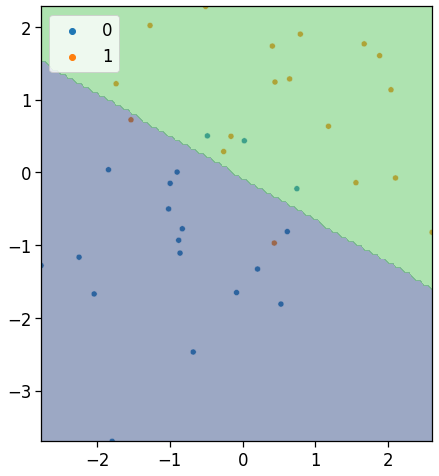

In [17]:
visualize_model(x_train, y_train, lsc)

In [18]:
def plot_learning_curve(err_all):
    err = [err[1][1] for err in err_all]
    plt.plot(np.arange(len(err)), err, 'r-')

#### Gradient Descent

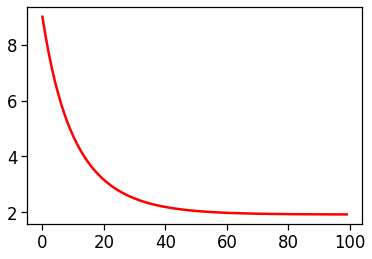

In [19]:
lsc.gd(x_train, y_train_trans, num_epochs=100, reg_rate=0, lr = 0.001)
plot_learning_curve(lsc.err_all)

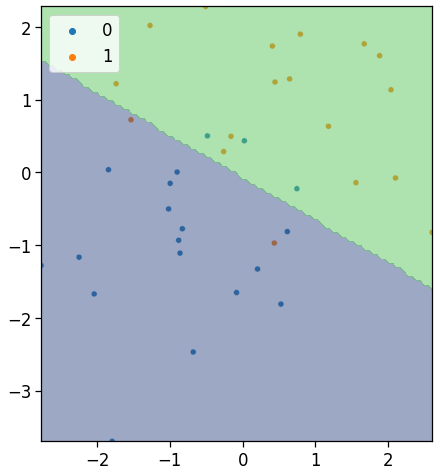

In [20]:
visualize_model(x_train, y_train, lsc)

#### Stochastic Gradient Descent

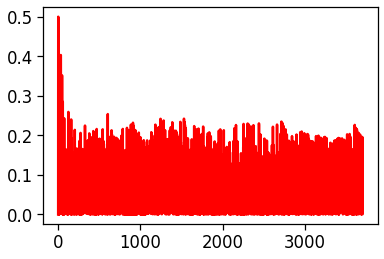

In [21]:
lsc.sgd(x_train, y_train_trans, num_epochs=100, reg_rate=0)
plot_learning_curve(lsc.err_all)

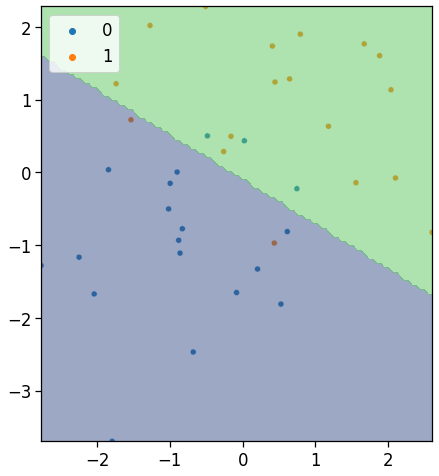

In [22]:
visualize_model(x_train, y_train, lsc)

#### Evaluation metrics

In [23]:
y_test_hat = lsc.predict(x_test)

In [24]:
tp = np.where((y_test == 1) & (y_test_hat == 1), 1, 0).sum()
tn = np.where((y_test == 0) & (y_test_hat == 0), 1, 0).sum()
fp = np.where((y_test == 0) & (y_test_hat == 1), 1, 0).sum()
fn = np.where((y_test == 1) & (y_test_hat == 0), 1, 0).sum()

In [25]:
tp, tn, fn, fp

(7, 5, 0, 1)

In [26]:
def precision(tp, fp):
    if (tp + fp) == 0:
        return NaN
    return tp / (tp + fp)

In [27]:
def recall(tp, fn):
    if (tp + fn) == 0:
        return NaN
    return tp / (tp + fn)

In [28]:
def accuracy(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn)

In [29]:
def f1_score(pr, r):
    return 2 * ((pr * r) / (pr + r))

In [30]:
pr = precision(tp, fp)
r = recall(tp, fn)
pr, r, accuracy(tp, tn, fp, fn), f1_score(pr, r)

(0.875, 1.0, 0.9230769230769231, 0.9333333333333333)

### Classification on data with outliers.

In [31]:
x_train , x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_outliers=True)

In [32]:
assert x_train.shape[0] == y_train.shape[0], "Not enough labels for all training samples"

In [33]:
assert x_test.shape[0] == y_test.shape[0], "Not enough labels for all test samples"

In [34]:
lsc = LeastSquareClassification()
lsc.fit(x_train, y_train_trans, reg_rate=0)

(41, 3) (41, 2) (3, 2)


array([[ 0.56648961,  0.43351039],
       [-0.1576575 ,  0.1576575 ],
       [-0.01812434,  0.01812434]])

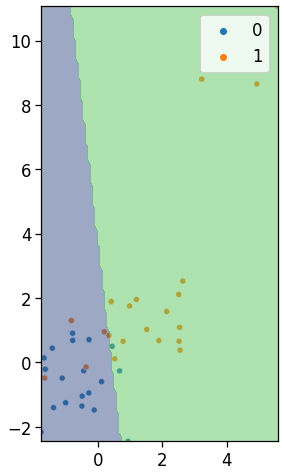

In [35]:
visualize_model(x_train, y_train, lsc)

In [36]:
def plot_learning_curve(err_all):
    err = [err[1][1] for err in err_all]
    plt.plot(np.arange(len(err)), err, 'r-')

#### Gradient Descent

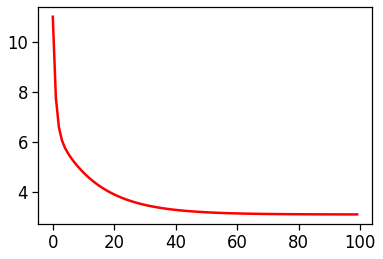

In [37]:
lsc.gd(x_train, y_train_trans, num_epochs=100, reg_rate=0, lr = 0.001)
plot_learning_curve(lsc.err_all)

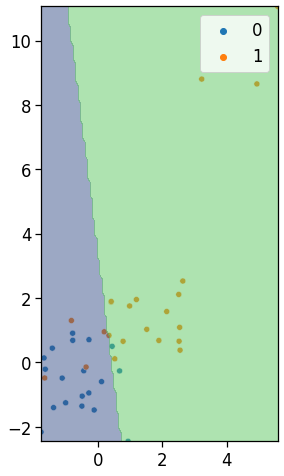

In [38]:
visualize_model(x_train, y_train, lsc)

#### Stochastic Gradient Descent

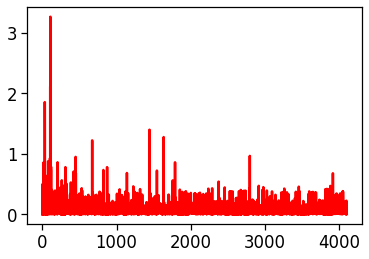

In [39]:
lsc.sgd(x_train, y_train_trans, num_epochs=100, reg_rate=0)
plot_learning_curve(lsc.err_all)

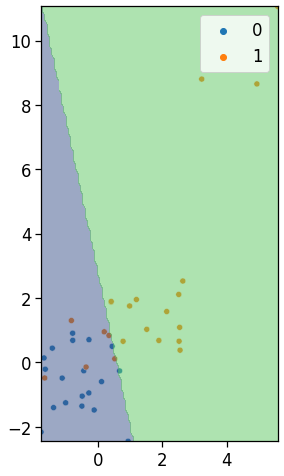

In [40]:
visualize_model(x_train, y_train, lsc)

### Classification on data with more than 2 classes per label.

In [41]:
x_train , x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_class=True)

In [42]:
assert x_train.shape[0] == y_train.shape[0], "Not enough labels for all training samples"

In [43]:
assert x_test.shape[0] == y_test.shape[0], "Not enough labels for all test samples"

In [44]:
lsc = LeastSquareClassification()
lsc.fit(x_train, y_train_trans, reg_rate=0)

(56, 3) (56, 3) (3, 3)


array([[ 0.52825835,  0.28247359,  0.18926806],
       [-0.08910195, -0.04917618,  0.13827813],
       [-0.20389303,  0.09744845,  0.10644458]])

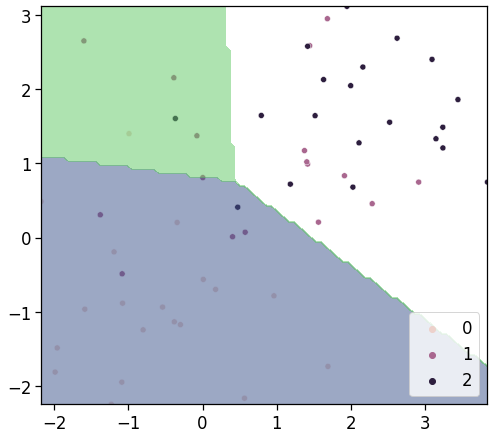

In [45]:
visualize_model(x_train, y_train, lsc)

In [46]:
def plot_learning_curve(err_all):
    err = [err[1][1] for err in err_all]
    plt.plot(np.arange(len(err)), err, 'r-')

#### Gradient Descent

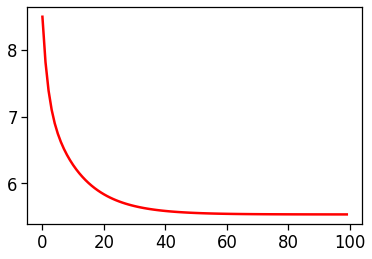

In [47]:
lsc.gd(x_train, y_train_trans, num_epochs=100, reg_rate=0, lr = 0.001)
plot_learning_curve(lsc.err_all)

In [48]:
y_test_predict = lsc.predict(x_test)
#using the sklearn to generate the evaluate metrics, rather than using our functions
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.12      0.22         8
           2       0.42      1.00      0.59         5

    accuracy                           0.63        19
   macro avg       0.81      0.71      0.60        19
weighted avg       0.85      0.63      0.56        19



### Classification on data that fit polynomial (circle)

In [49]:
from sklearn.datasets import make_circles
x, y = make_circles()

D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [50]:
x_poly = polynomial_transform(x, degree=2)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

In [51]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((75, 6), (25, 6), (75,), (25,))

In [52]:
y_train_trans = LabelTransformer().encode(y_train)
y_test_trans = LabelTransformer().encode(y_test)

<AxesSubplot:>

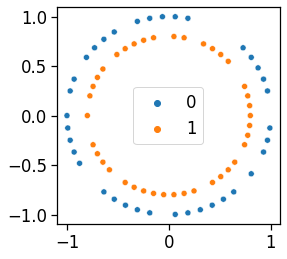

In [53]:
f = plt.figure(figsize=(4,4))
sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=y_train)

In [54]:
lsc = LeastSquareClassification()
lsc.fit(x_train, y_train_trans, reg_rate=0)

(75, 6) (75, 2) (6, 2)


array([[-1.77777778e+00,  2.77777778e+00],
       [-7.63623731e-17, -9.38525392e-18],
       [-7.11159489e-17,  0.00000000e+00],
       [ 2.77777778e+00, -2.77777778e+00],
       [-1.07059901e-16, -2.14119801e-16],
       [ 2.77777778e+00, -2.77777778e+00]])

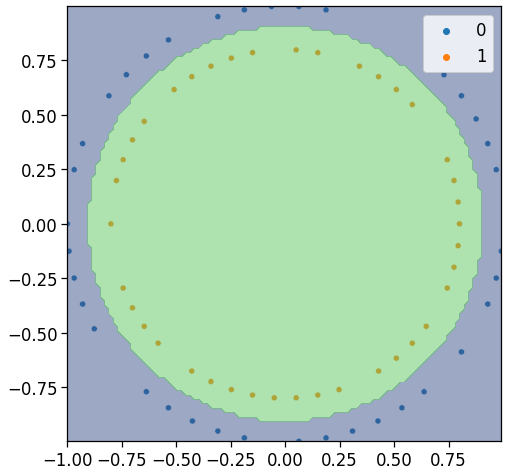

In [55]:
visualize_model(x_train, y_train, lsc, degree=2)

In [56]:
y_test_predict = lsc.predict(x_test)
#using the sklearn to generate the evaluate metrics, rather than using our functions
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        11

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



### Perceptron

In [57]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(1234)
%matplotlib inline

In [58]:
# Same implementation as in the previous section
def polynomial_transform(x, degree):
    if x.ndim == 1:
        x = x[:, None]

    features = [np.ones(len(x))] #a list of np-arrays with all 1.

    for degree in range(1, degree + 1):
        for item in combinations(x.T, degree):
            features.append(compute_new_features(item))
            
    return np.asarray(features).T

In [59]:
def create_toy_data(factor=3):
    x0 = np.random.normal(size=50).reshape(-1, 2) - factor
    x1 = np.random.normal(size=50).reshape(-1, 2) + factor
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25)-1, np.ones(25)]).astype(np.int)

In [60]:
# same as in previous section
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

def visualize_model(X_train, labels, lsc, degree=1):
    f = plt.figure(figsize=(8,8))

    x1_min = np.min(x_train[:,1])
    x1_max = np.max(x_train[:,1])
    x2_min = np.min(x_train[:,2])
    x2_max = np.max(x_train[:,2])
    
    x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100)) 
    x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test = lsc.predict(x_test_poly)
    
    sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1], hue=labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100,100), alpha=0.5, levels=np.linspace(0,1,3))
    plt.gca().set_aspect('equal', adjustable='box')

#### Perceptron class

In [61]:
 class Perceptron(object):
  def __init__(self):
      pass
    
  def predict(self,X):
    z = X @ self.w
    return np.where (z >= 0, 1, -1)
 
  def loss(self,X,y,reg_rate):
    return np.sum(np.maximum(-1 * self.predict(X) * y, np.zeros(y.shape[0])))

  def fit(self,X, y, reg_rate=0):
    self.w = np.linalg.solve(X.T @ X + reg_rate * np.eye(X.shape[-1]), X.T@y)
    print(X.shape, y.shape, self.w.shape)
    return self.w
  
  def train(self, X, y, num_epochs, lr=0.001):
    self.w = np.zeros(X.shape[1])
    self.w_all = []
    self.err_all = []
    for i in np.arange(0, num_epochs):
        errors = 0
        for xi, target in zip(X, y):
            self.w += lr * (target - self.predict(xi)) * xi
            errors += np.maximum(-1 * self.predict(X) * y, np.zeros(y.shape[0]))
        self.err_all.append(errors)
        self.w_all.append(self.w)
#         print("w:", self.w)
#         print("J(w):", self.err_all[-1])
    return self.w

#### Linearly separable case

In [62]:
x, y = create_toy_data()
x_poly = polynomial_transform(x, degree=1)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


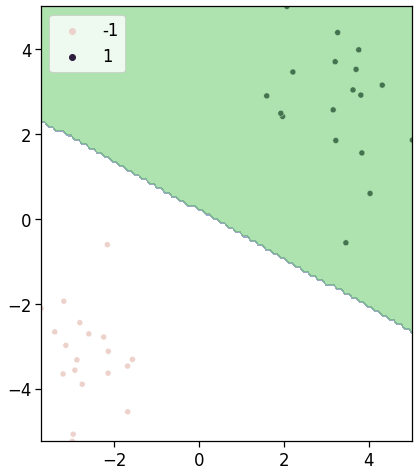

In [63]:
p = Perceptron()
p.train(x_train, y_train, num_epochs=100, lr=1)
visualize_model(x_train, y_train, p, degree=1)

#### Non-linearly separable case

In [64]:
x, y = create_toy_data(factor=0.5)
x_poly = polynomial_transform(x, degree=1)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


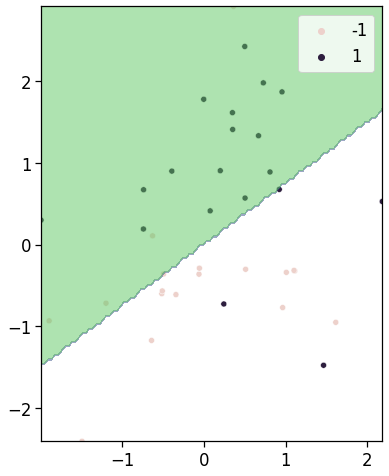

In [65]:
p = Perceptron()
p.train(x_train, y_train, num_epochs=100, lr=1)
#In non-linear separable case, the classification doesn't converge, but oscillate.  Print loss to see.
visualize_model(x_train, y_train, p, degree=1)